In [140]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm.notebook import tqdm
import os
import sys
import numpy as np
from torchvision import datasets
from torchvision import transforms as T
from torchvision.io import read_image
import matplotlib.ticker as mtick
import io
from IPython.display import clear_output, display
import PIL.Image as Image
import matplotlib.ticker as mticker
import zipfile
import torchvision.models as models
from torch.optim import Adam, SGD
from time import sleep
import h5py as h5
import torch.nn.functional as F
import random

%matplotlib inline

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [142]:
device

device(type='cuda')

In [143]:
train_x = np.array(h5.File("Signs_Data_Training.h5", "r")["train_set_x"])

In [144]:
train_y = np.array(h5.File("Signs_Data_Training.h5", "r")["train_set_y"])

In [145]:
test_x = np.array(h5.File("Signs_Data_Testing.h5", "r")["test_set_x"])

In [146]:
test_y = np.array(h5.File("Signs_Data_Testing.h5", "r")["test_set_y"])

#### Reading data

In [147]:
class HandDataset(Dataset):
    def __init__(self, train_p=None, dat=None, train=True, transform=None, one_hot=False, zipf=False):
        
        assert (train_p is not None and dat is None) or (train_p is None or dat is not None)
        
        if train_p is not None:
            self._train_p = train_p
            self._one_hot = one_hot
            self._train = train
            self._zipf = zipf
            self._train_x, self._train_y = self.__get_tensors()
        else:
            self._train_x, self._train_y = dat
    
    def __get_tensors(self):   
        if self._zipf:
            zf = zipfile.ZipFile(self._train_p, "r")
            if self._train:
                train_files = [i for i in zf.namelist() if ("train" in i) and (i.endswith("png"))]
            else:
                train_files = [i for i in zf.namelist() if ("test" in i) and (i.endswith("png"))]
            
            train_x = torch.stack(tuple(torch.from_numpy(self.__read_io_np(zf, f)) for f in train_files))
                
        else:
            train_files = [os.path.join(os.getcwd(), self._train_p, d) for d in os.listdir(self._train_p)]
            train_x = torch.stack(tuple(read_image(f) for f in train_files))
                
        if self._one_hot:  
            train_y = F.one_hot(torch.Tensor([int(f[-6]) for f in train_files]).long(), 6)
        else:
            train_y = torch.Tensor([int(f[-6]) for f in train_files]).long()
            
        return train_x, train_y
            
    
    def __read_io_np(self, zf, f):
        return np.array(Image.open(io.BytesIO(bytearray(zf.read(f)))))
        
        return train_x, train_y
    
    def __len__(self):
        return len(self._train_x)
    
    def __getitem__(self, idx):
        if transform:
            return torch.squeeze(transform(self._train_x[idx])), self._train_y[idx]
        return self._train_x, self._train_y
    
  

In [148]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [149]:
transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    #T.Grayscale(),
    #T.Lambda(lambda x: x.repeat(3, 1, 1)),
    T.Normalize(mean=MEAN, std=STD)
]
)

In [150]:
train_ds = HandDataset(dat=(train_x, train_y), train=True, transform=transform, one_hot=False, zipf=True)

In [151]:
test_ds = HandDataset(dat=(test_x, test_y), train=False, transform=transform, one_hot=False, zipf=True)

#### Visualization

In [152]:
r_images = [random.randint(1, 500) for _ in range(9)]

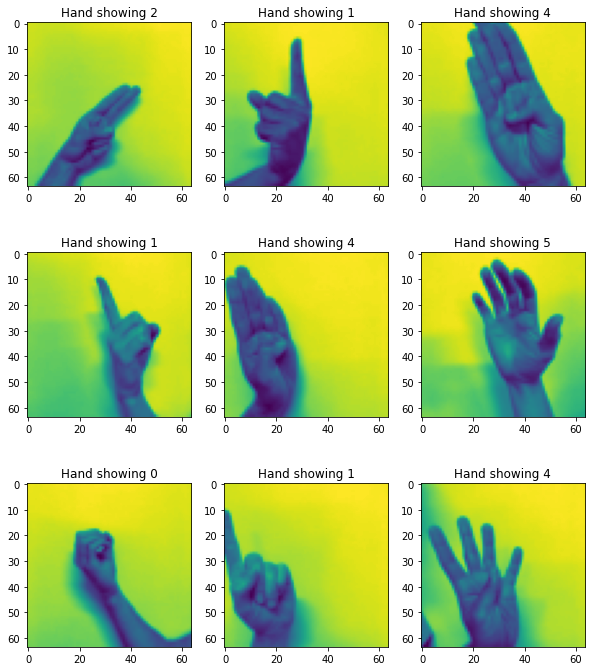

In [153]:
fig, axes = plt.subplots(3, 3, figsize=(10,12))
c = 0
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(train_ds[r_images[c]][0][2])
        axes[i, j].set_title("Hand showing {}".format(train_ds[r_images[c]][1]))
        c += 1

In [154]:
model = models.densenet121(pretrained=True)

In [155]:
# def get_model(name="densenet121", 
#               layer="classifier", 
#               device = "cpu",
#               layer_num=0, **kwargs):
    
#     if name == "densenet121":
#         model = models.densenet121(pretrained=True).to(device)
#     elif name == "alexnet":
#         model = models.alexnet(pretrained=True).to(device)
#     elif name == "resnet":
#         model = models.resnet101(pretrained=True).to(device)
#     elif name == "vgg":
#         model = models.vgg11(pretrained=True).to(device)
#     else:
#         raise Exception("model not found")
        
#     if layer == "classifier":
#         model.classifier[layer_num](kwargs)
    
#     elif layer == "features":
#         model.features[layer_num](kwargs)
    
    
#     return model

In [156]:
count = 0
for c in model.children():
    if count < 1:
        for param in c.parameters():
            param.requires_grad = False
    

In [157]:
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=6, bias=True)

In [158]:
model = model.to(device)

In [159]:
train_batch = 32

In [160]:
test_batch = 16

In [161]:
train_loader = DataLoader(train_ds, train_batch, shuffle=True)

In [162]:
test_loader = DataLoader(test_ds, test_batch, shuffle=True)

In [163]:
num_epoch = 20

In [164]:
opt = Adam(model.parameters(), lr=0.001)

In [165]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []

In [166]:
range_ep = range(num_epoch)
with tqdm(total=len(range_ep), file=sys.stdout) as pbar:
    for ep in range_ep:
        train_ep_loss, train_ep_acc = [], []
        val_ep_acc = []
        c = 0
        #print("Training...")
        for im, label in iter(train_loader):
            im = im.to(device)
            label = label.to(device)

            model.train()
            opt.zero_grad()
            outp = model(im)
            loss = F.cross_entropy(outp, label)
            loss.backward()

            opt.step()

            train_ep_loss.append(loss.item())

        c_loss = np.mean(train_ep_loss)
        train_loss.append(c_loss)

        #print("Train loss: {} \n".format(c_loss))

        #print("Testing accuracy on train ...")
        for im, label in iter(train_loader):
            im = im.to(device)
            label = label.to(device)

            model.eval()
            with torch.no_grad():
                pred = model(im)
                correct = torch.argmax(pred, dim=1) == label
                train_ep_acc.extend(correct.cpu().numpy().tolist())

        c_acc1 = np.mean(train_ep_acc)
        train_acc.append(c_acc1)

        #print("Train acc: {} \n".format(c_acc1))

        for im, label in iter(test_loader):
            im = im.to(device)
            label = label.to(device)

            model.eval()
            with torch.no_grad():
                pred = model(im)
                correct = torch.argmax(pred, dim=1) == label
                val_ep_acc.extend(correct.cpu().numpy().tolist())

        c_acc2 = np.mean(val_ep_acc)
        val_acc.append(c_acc2)

        #print("Test acc: {}".format(c_acc2))

        pbar.set_description("Train loss: {} Train Acc: {} Test Acc: {} \n".format(c_loss, c_acc1, c_acc2))
        pbar.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]

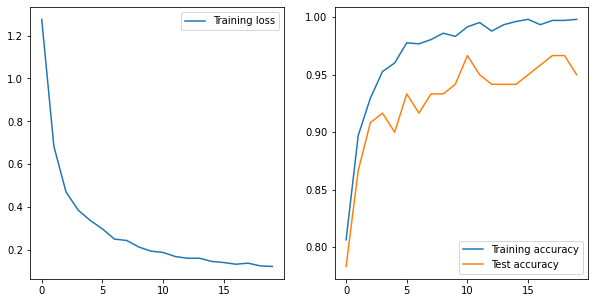

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(range_ep, train_loss)
axes[1].plot(range_ep, train_acc)
axes[1].plot(range_ep, val_acc)
axes[0].legend(["Training loss"])
axes[1].legend(["Training accuracy", "Test accuracy"])